In [26]:
using DifferentialEquations, Plots
using Revise
using DiffEqOperators
pyplot()

Plots.PyPlotBackend()

In [62]:
# Obtained from https://en.wikipedia.org/wiki/Telegrapher%27s_equations#Lossy_transmission_line
function telegrapher(L, C, R=0, G=0 ;n=100, vs=t->1.0, is=t->0.0)
    if L == 0 || C == 0
        error("Both the inductance and capacitance need to be non-zero.")
    end
    return function(t,u,du)
        B2(t,view(u,n+1:2n),view(du,1:n))
        scale!(view(du,1:n), -1/L)

        B1(t,view(u,1:n),view(du,n+1:2n))
        scale!(view(du,n+1:2n), -1/C)
        
        @. u[1:n] += G*u[1:n]
        @. u[n+1:2n] += R*u[n+1:2n]
        
        # Update the boundary conditions after every iteration according to dependency on time
        update_coefficients!(B1, BC=(vs(t), vs(t)))
        update_coefficients!(B2, BC=(is(t), is(t)))
        
    end
end

telegrapher (generic function with 3 methods)

In [54]:
function tline_solve(u0,vs,is,L,C,R=0,G=0;t=(0.,2.),n=100)
    dx = 1/(n-1)
    B1 = LinearOperator{Float64}(1,2,dx,n,:Dirichlet,:Dirichlet;BC=(vs(0),vs(0)));
    B2 = LinearOperator{Float64}(1,2,dx,n,:Dirichlet,:Dirichlet;BC=(is(0),is(0)));

    prob = DifferentialEquations.ODEProblem(telegrapher(L,C,R,G,n=n),u0,t)
    solver = CVODE_BDF()
    sol = DifferentialEquations.solve(prob, solver, reltol=1e-8, abstol=1e-8,saveat=0.01)
    return sol
end

tline_solve (generic function with 3 methods)

In [56]:
n = 500;
u0 = vcat(1,zeros(2n-1));
soln = tline_solve(u0, t->1.0, t->0.0,2,2;n=n);

In [45]:
B1.boundary_condition

Base.RefValue{Tuple{Tuple{Float64,Float64,Any},Tuple{Float64,Float64,Any}}}(((1.0, 0.0, 1.0), (1.0, 0.0, 1.0)))


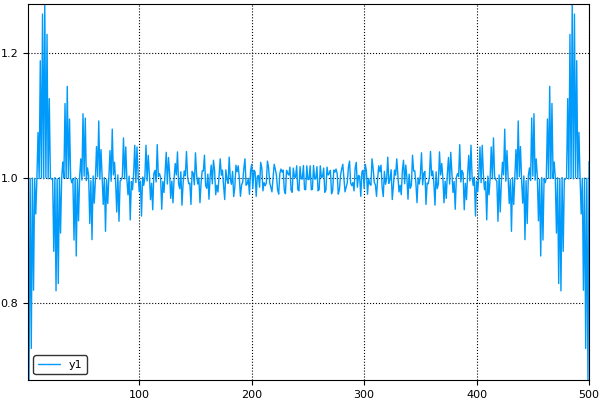

In [57]:
plot(soln(2.0)[1:n]) # Voltage distribution


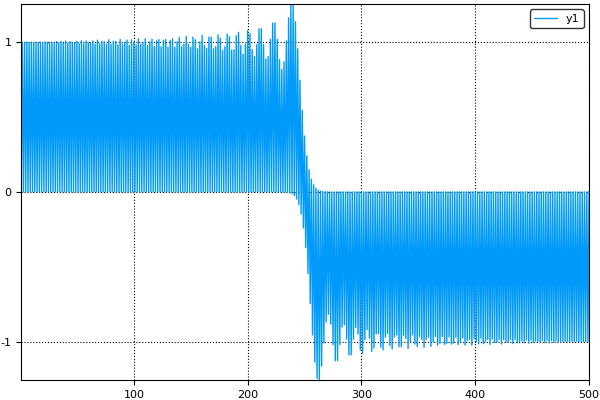

In [58]:
plot(soln(1.0)[n+1:2n]) # Current Distribution


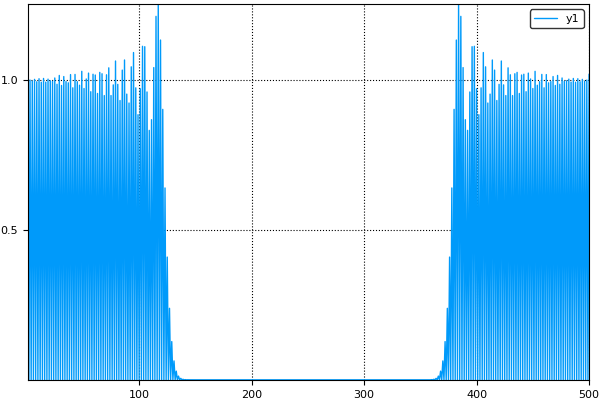

In [59]:
plot(soln(0.5)[1:n]) # Voltage distribution


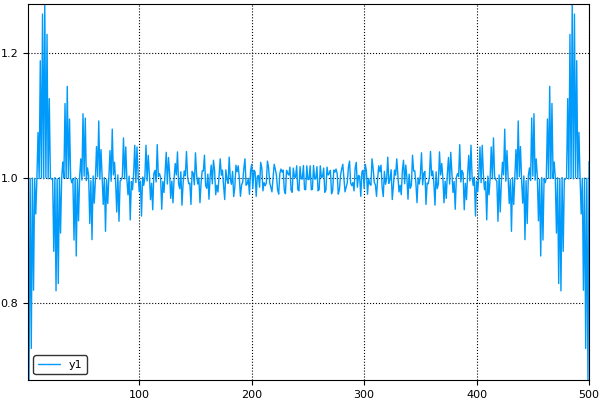

In [60]:
plot(soln(2.0)[1:n]) # Voltage distribution


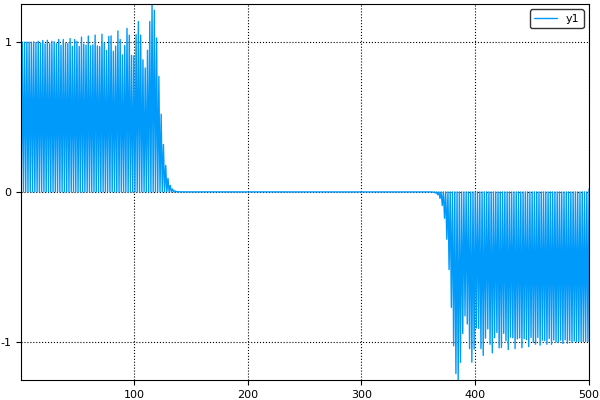

In [61]:
plot(soln(0.5)[n+1:2n]) # current distribution 